# JRC microthesauri, no preprocessing

### Data Fetching and Preparation




In [1]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

FN='jrc_microthesauri_en_svm.csv'

bs = 32

**Get the dataset**





In [2]:
df_raw = pd.read_csv(FN, delimiter=';')
df_raw.head(2)

,docid,text,100163,100164,100165,100166,100167,100168,100169,100170,...,100279,100280,100281,100282,100283,100284,100285,100286,100287,100288
0,jrc51976FC0135-en,[ pic ] | COMMISSION OF THE EUROPEAN COMMUNITI...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,jrc31996L0071-en,DIRECTIVE 96 / 71 / EC OF THE EUROPEAN PARLIAM...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
columns = list(df_raw) 

## transfrom n hot to simple labels
new_rows = []
for i, j in df_raw.iterrows(): 
    labels = [c for c in columns if c.startswith('1') and j[c]==1]
    new_rows.append( (j['text'], ';'.join(labels)) )

df = pd.DataFrame(new_rows)
df.columns = ['text', 'labels']

df.head(10)


,text,labels
0,[ pic ] | COMMISSION OF THE EUROPEAN COMMUNITI...,100175;100237;100238;100240
1,DIRECTIVE 96 / 71 / EC OF THE EUROPEAN PARLIAM...,100227;100233;100234;100236
2,COMMISSION REGULATION ( EC ) No 1147 / 96 of 2...,100215;100244;100254
3,COMMISSION DECISION of 11 October 1996 laying ...,100192;100193;100252;100279;100282;100283
4,COMMISSION DECISION of 11 October 1996 laying ...,100192;100193;100252;100280;100282
5,COUNCIL DIRECTIVE 96 / 24 / EC of 29 April 199...,100175;100193;100196;100250;100258
6,COMMISSION DIRECTIVE 96 / 68 / EC of 21 Octobe...,100215;100234;100249;100258;100268
7,COUNCIL DIRECTIVE 96 / 61 / EC of 24 September...,100242;100244
8,COMMISSION DECISION of 17 October 1996 amendin...,100171;100193;100245;100249;100254;100257
9,COUNCIL DIRECTIVE 96 / 29 / EURATOM of 13 May ...,100215;100224;100234;100266


In [4]:
FN = 'converted.csv'
df.to_csv(FN)
del df_raw


## Reuse Fine-tuned of the language model from "JRC_basic" folder


In [2]:
data_lm = load_data(Path('.'), 'data_lm.pkl', bs=bs)

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [3]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [7]:
print(FN)

converted.csv


In [8]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [9]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', ',', 'of', '|', '.', 'and', 'to', 'in', ')', '(', '-']


In [4]:
data_clas = load_data(Path('.'), 'data_clas.pkl', bs=bs)

In [5]:
data_clas.show_batch()

text,target
xxbos xxup section xxup iii xxup commission xxup contents xxup volume xxup ii — xxup section xxup iii : xxup commission — xxmaj title 3 : xxmaj surpluses available — xxmaj title 4 : xxmaj revenue accruing from persons working with the institutions and other xxmaj community bodies — xxmaj title 5 : xxmaj revenue accruing from the administrative operation of the institution — xxmaj title 6 : xxmaj contributions,100177;100205
xxbos xxmaj list of credit institutions provided for in xxmaj article 11 of xxmaj directive 2000 / 12 / xxup ec ( 2005 / c 032 / 01 ) xxmaj article 11 of xxmaj directive 2000 / 12 / xxup ec of the xxmaj european xxmaj parliament and of the xxmaj council of 20 xxmaj march 2000 relating to the taking up and pursuit of the business of credit institutions,100200;100220;100282
"xxbos xxup commission xxup directive 98 / 98 / xxup ec of 15 xxmaj december 1998 adapting to technical progress for the 25 time xxmaj council xxmaj directive 67 / 548 / xxup eec on the approximation of the laws , regulations and administrative provisions relating to the classification , packaging and labelling of dangerous substances ( xxmaj text with xxup eea relevance ) xxup the xxup commission xxup of",100175;100196;100220;100244
"xxbos xxmaj common position ( xxup ec ) xxmaj no 17 / 2006 adopted by the xxmaj council on 27 xxmaj june 2006 with a view to adopting xxmaj regulation ( xxup ec ) xxmaj no / 2006 … of the xxmaj european xxmaj parliament and of the xxmaj council of … concerning the xxmaj registration , xxmaj evaluation , xxmaj authorisation and xxmaj restriction of xxmaj chemicals ( xxup",100169;100174;100196;100220;100226;100242;100269
"xxbos xxmaj commission xxmaj directive 2001 / 59 / xxup ec of 6 xxmaj august 2001 adapting to technical progress for the 28th time xxmaj council xxmaj directive 67 / 548 / xxup eec on the approximation of the laws , regulations and administrative provisions relating to the classification , packaging and labelling of dangerous substances ( xxmaj text with xxup eea relevance ) xxup the xxup commission xxup of",100175;100196;100220;100244


In [6]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-JRC')


In [7]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of BCEWithLogitsLoss()
BCEWithLogitsLoss()


In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


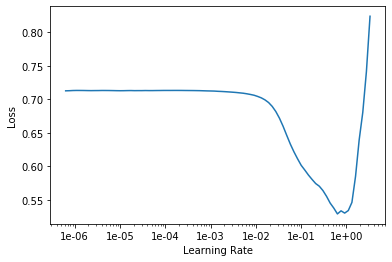

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2, slice(1e-1,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.126340,0.128604,0.959962,0.134139,0.415983,0.196693,0.078071,0.506233,0.417475,0.195782,0.129832,0.796202,0.425225,0.191475,0.227409,0.877452,0.430284,0.183779,0.286646,0.931603,0.443048,0.170597,0.321155,0.948532,0.451431,0.158888,0.302645,0.956067,0.459283,0.145129,0.266745,0.959962,0.473046,0.131962,0.220850,18:46
1,0.111104,0.102011,0.968039,0.195334,0.700530,0.198081,0.082793,0.582397,0.702340,0.196409,0.153744,0.865444,0.712021,0.191323,0.307402,0.926381,0.718647,0.184419,0.385154,0.957207,0.736427,0.172157,0.410959,0.965238,0.752781,0.160823,0.371981,0.967656,0.769099,0.147799,0.318454,0.968039,0.787151,0.137742,0.264398,18:52


## Results:

learn.fit_one_cycle(1, slice(1e-2,1e-1), moms=(0.8,0.7)): 

    0	0.010093	0.008351	0.998479	0.874526	0.052546	46:22 (colab)
    
learn.fit_one_cycle(1, slice(2e-2,2e-1), moms=(0.8,0.7)):

    # old: 0	0.009459	0.008237	0.998506	0.772035	0.062515	19:41
    0	0.009326	0.009061	0.998467	0.719809	0.069594	19:01
    
### preprocessing corpus

learn.fit_one_cycle(1, slice(1e-1,1e-1), moms=(0.8,0.7))  

    first part: 0	0.007484	0.006419	0.998603	0.827936	0.723389	0.184216	0.021517\
    last part: 0.998603	0.794771	0.144744	0.238704	04:38
    


In [ ]:
#learn.export()

In [18]:
learn.save('first')

In [ ]:
learn.load('first')

Why gradual unfreeze? Give example of Image detection.

In [20]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


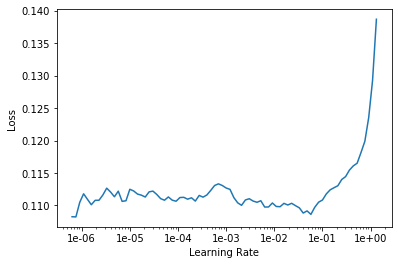

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.102726,0.092592,0.970379,0.265194,0.728061,0.285831,0.092901,0.646428,0.730104,0.284654,0.186491,0.881376,0.737567,0.279188,0.355600,0.934394,0.743619,0.272219,0.439556,0.961402,0.760002,0.260219,0.477661,0.967939,0.776620,0.248514,0.448407,0.969953,0.793014,0.237012,0.401159,0.970379,0.806242,0.224266,0.348490,20:39
1,0.092547,0.083792,0.972889,0.323272,0.752539,0.373934,0.103218,0.685483,0.753791,0.372689,0.217270,0.891282,0.758796,0.367905,0.395411,0.938724,0.768535,0.362331,0.476547,0.962588,0.781885,0.348757,0.518499,0.969584,0.795894,0.333876,0.505836,0.972221,0.811015,0.320576,0.478079,0.972889,0.824757,0.308696,0.437475,19:50


### Results:
    
learn.fit_one_cycle(2, slice(1e-2/(2.6xx4),1e-2), moms=(0.8,0.7)) (after 2e-2,2e-1) in step one:

    epoch	train_loss	valid_loss	accuracy_thresh	custom_precision	custom_recall	time
    0	0.008408	0.083658	0.996215	0.639583	0.135676	19:34
    1	0.007711	0.006891	0.998587	0.751884	0.164432	19:30
    2	0.006967	0.006600	0.998611	0.750787	0.185833	19:47


In [23]:
learn.save('second')

In [24]:
learn.load('second');

In [25]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


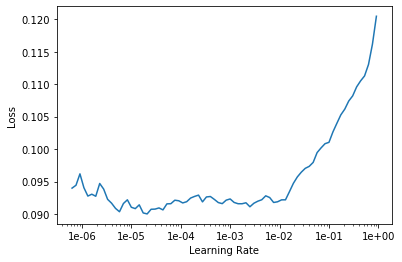

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(4, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
learn.fit_one_cycle(5, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.088686,0.082837,0.973216,0.335916,0.754425,0.383610,0.106019,0.693417,0.755847,0.382111,0.225838,0.893420,0.762928,0.375577,0.405750,0.939658,0.769443,0.369070,0.486767,0.962943,0.783951,0.355806,0.530438,0.969940,0.796472,0.342432,0.519732,0.972481,0.810638,0.328474,0.487092,0.973216,0.823187,0.314017,0.449555,20:47
1,0.087730,0.078931,0.974174,0.358244,0.782074,0.396585,0.111297,0.708293,0.783913,0.395384,0.240160,0.899320,0.788705,0.390029,0.427952,0.943609,0.797258,0.383754,0.512311,0.966093,0.809619,0.372112,0.557313,0.972103,0.821310,0.358736,0.541692,0.973845,0.832486,0.345533,0.507137,0.974174,0.843627,0.333124,0.468788,21:46
2,0.084594,0.076078,0.974831,0.399068,0.771104,0.434303,0.122983,0.728161,0.772412,0.433253,0.261311,0.904578,0.777959,0.427720,0.448291,0.945351,0.784119,0.421565,0.526994,0.966385,0.796825,0.411561,0.574223,0.972309,0.809034,0.398534,0.566416,0.974425,0.821665,0.385877,0.538563,0.974831,0.834546,0.373194,0.502151,20:42
3,0.076807,0.074105,0.975488,0.403144,0.790583,0.439957,0.121345,0.744577,0.791771,0.439058,0.268092,0.910870,0.796736,0.433365,0.460589,0.948584,0.802444,0.425514,0.540790,0.968236,0.814775,0.412559,0.585895,0.973635,0.826740,0.400648,0.578489,0.975336,0.837271,0.385207,0.550397,0.975488,0.848467,0.373710,0.510615,21:00
4,0.076008,0.073660,0.975848,0.416783,0.788304,0.455926,0.122637,0.750565,0.789304,0.454788,0.268086,0.911232,0.795485,0.450127,0.460989,0.948407,0.803177,0.442969,0.540867,0.967989,0.814155,0.429959,0.587979,0.973506,0.824772,0.416152,0.581716,0.975413,0.835275,0.404171,0.557451,0.975848,0.843493,0.391170,0.523296,20:10


### Results:

learn.fit_one_cycle(3, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7))

    epoch	train_loss	valid_loss	accuracy_thresh	custom_precision	custom_recall	time
    0	0.007680	0.007027	0.998588	0.773600	0.163029	21:17
    1	0.006924	0.006516	0.998621	0.807463	0.166123	21:11
    2	0.006826	0.006296	0.998640	0.803096	0.191780	21:05
    
    
second run, same settings:


In [28]:
learn.save('third')

In [ ]:
learn.load('third')

In [9]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


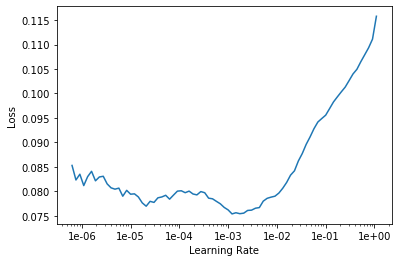

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
#learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
#learn.fit_one_cycle(15, slice(7e-3/(2.6**4),7e-3), moms=(0.8,0.7)) ## works well
#learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.077190,0.073375,0.975764,0.398137,0.793735,0.447438,0.120067,0.740075,0.794664,0.446320,0.267015,0.909423,0.799121,0.440350,0.460598,0.948491,0.805629,0.432579,0.542887,0.968340,0.818268,0.419270,0.589743,0.973893,0.828904,0.406475,0.580888,0.975629,0.840865,0.393868,0.554401,0.975764,0.850960,0.381949,0.516213,22:41
1,0.076886,0.072961,0.976020,0.443352,0.787240,0.463819,0.132721,0.761266,0.788091,0.463075,0.286818,0.915267,0.792344,0.458214,0.473600,0.950441,0.797852,0.451373,0.551560,0.968757,0.810037,0.438342,0.594545,0.973893,0.821123,0.425088,0.588567,0.975459,0.831111,0.410948,0.559643,0.976020,0.842333,0.398762,0.530306,21:27
2,0.077401,0.072526,0.976270,0.461695,0.779810,0.480080,0.136046,0.765806,0.780914,0.478766,0.292478,0.913816,0.784970,0.473514,0.471257,0.948366,0.790618,0.466538,0.547275,0.967610,0.801760,0.453915,0.595647,0.973474,0.811704,0.438642,0.598212,0.975502,0.822961,0.424970,0.577430,0.976270,0.835035,0.410849,0.550818,22:53
3,0.075152,0.071148,0.976668,0.447186,0.812298,0.462941,0.131970,0.769490,0.813554,0.462012,0.293177,0.920764,0.817899,0.457647,0.487629,0.954187,0.822831,0.451142,0.569676,0.970751,0.831067,0.436893,0.609027,0.975048,0.842048,0.422481,0.598057,0.976406,0.851515,0.411148,0.570491,0.976668,0.862841,0.398316,0.539155,22:30
4,0.074265,0.069954,0.976809,0.454008,0.793346,0.487185,0.132438,0.766191,0.794285,0.486316,0.293250,0.917624,0.799736,0.481919,0.487296,0.951930,0.806725,0.476142,0.569026,0.969718,0.816776,0.461735,0.612587,0.974910,0.826616,0.448881,0.609028,0.976363,0.839086,0.434375,0.583290,0.976809,0.849212,0.422445,0.554145,22:44
5,0.069953,0.069016,0.977382,0.468628,0.802651,0.498082,0.134005,0.783974,0.803536,0.496881,0.305904,0.924264,0.808247,0.490731,0.501337,0.954710,0.813036,0.484329,0.578715,0.970735,0.823728,0.472184,0.621588,0.975221,0.834544,0.459752,0.616161,0.976834,0.843548,0.445637,0.594404,0.977382,0.853263,0.431464,0.567156,22:05
6,0.068024,0.068485,0.977518,0.462825,0.792714,0.513284,0.132589,0.777764,0.793735,0.512018,0.297078,0.921507,0.798946,0.507253,0.495095,0.953473,0.806324,0.501797,0.577263,0.970336,0.817688,0.489355,0.624929,0.975243,0.829253,0.477292,0.623424,0.976913,0.836833,0.466532,0.603499,0.977518,0.847965,0.454694,0.578170,22:34
7,0.068748,0.067716,0.977747,0.473361,0.805974,0.508110,0.135175,0.786220,0.807016,0.506856,0.307761,0.924888,0.811803,0.501864,0.506817,0.954941,0.818110,0.496371,0.583298,0.971218,0.829862,0.484691,0.628983,0.975789,0.837420,0.472960,0.626371,0.977339,0.846414,0.460213,0.606499,0.977747,0.855798,0.446469,0.578555,23:05
8,0.067362,0.067486,0.977806,0.471967,0.802617,0.512921,0.134837,0.785862,0.803603,0.512066,0.306815,0.924944,0.809087,0.506845,0.506056,0.955142,0.815111,0.501192,0.584164,0.971186,0.826579,0.489256,0.628165,0.975848,0.836794,0.476731,0.628628,0.977369,0.844734,0.463545,0.607232,0.977806,0.854881,0.451234,0.581347,22:16
9,0.064797,0.067592,0.977792,0.458654,0.801122,0.514294,0.130007,0.779726,0.802240,0.513345,0.293510,0.923000,0.806052,0.508147,0.502757,0.954105,0.812642,0.502419,0.581045,0.970971,0.822418,0.490577,0.629510,0.975692,0.832830,0.479352,0.627458,0.977355,0.841846,0.466890,0.609419,0.977792,0.852223,0.453152,0.582431,22:50


In [12]:
learn.save('forth')

## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [13]:
# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()


In [14]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [21]:
thresh = 0.32

print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.6462747204781252
P (micro) 0.6959791726930865
R (micro) 0.6031964901284864

F1 (macro) 0.35785801793675226
P (macro) 0.46072863153239807
R (macro)  0.32369853613709615


## results:

without preprocessing -- 1st run:
  
    F1 (micro) 0.6693270575394794
    P (micro) 0.7342113139778509
    R (micro) 0.6149796302099655

    F1 (macro) 0.3890770790857555
    P (macro) 0.501579476235325
    R (macro)  0.34791195267245517




    

In [16]:
f1_score(y_true, y_pred>thresh, average='macro')

0.35220610652779927

In [17]:
y_true = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true.shape

((3503, 126), (3503, 126))

In [ ]:
metrics = classification_report(y_true, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)